<a href="https://colab.research.google.com/github/diem-ai/datascience-projects/blob/master/customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Colab Setup**

In [0]:
from google.colab import drive

drive.mount('/content/drive')

import sys


!pip install PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



**Import Libraries**

In [0]:
import pandas as pd
from scipy import stats
import numpy as np
# Allows the use of display() for DataFrames
from IPython.display import display 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set(style="ticks", color_codes=True)
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score


**Loading Dataset**

In [106]:

path = '/content/drive/My Drive/data/' # change it if running on local
filename = 'customers.csv'

data = pd.read_csv(path + filename)

data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [107]:
display(data.describe())

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


**Observation**

The mean & standard deviation are high among features. We can probably guess that data is noisy and skewed.

In [108]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
Channel             440 non-null int64
Region              440 non-null int64
Fresh               440 non-null int64
Milk                440 non-null int64
Grocery             440 non-null int64
Frozen              440 non-null int64
Detergents_Paper    440 non-null int64
Delicatessen        440 non-null int64
dtypes: int64(8)
memory usage: 27.6 KB


None

**Observation**

Dataset has 440 data points without NaN values

**Question** : How are products distrubuted in each channel?

<Figure size 1080x1440 with 0 Axes>

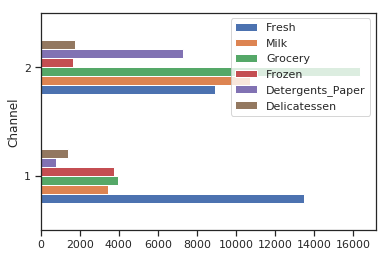

In [109]:
features = ['Channel', 'Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicatessen']

plt.figure(figsize=(15, 20))
data[features].groupby(['Channel']).mean().plot(kind='barh')
plt.legend(loc=1)

plt.show()

**Observation**

- As we can see, Fresh is largely distrubuted in Hotel/Restaurant/Cafe meanwhile Grocery is highly propotioned in distribution of Retail, following is Milk, Fresh and Detergents_Paper products
- Both channels sold very few Delicatessen and Frozen products


**Question**: Is there any degree of correlation of pairs of feature? In another words,  can sale of one product impacted to others? Is the data distributed normal?

To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data



<Figure size 360x360 with 0 Axes>

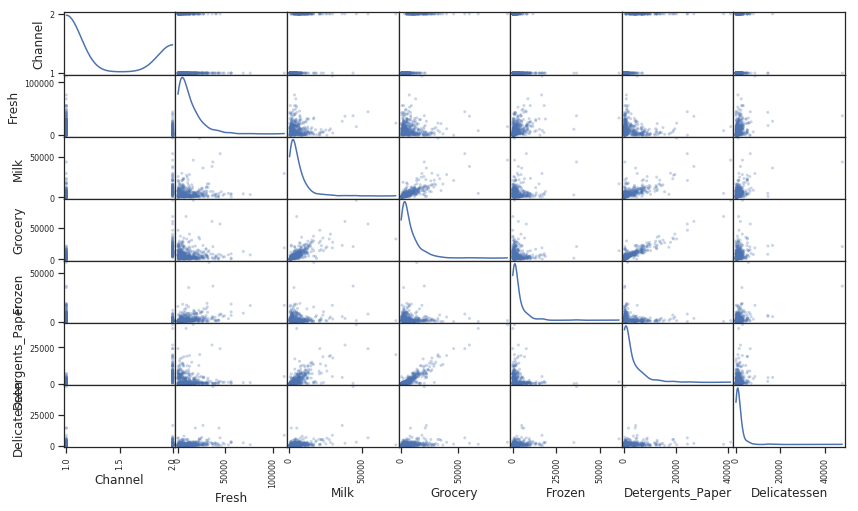

In [110]:
# Pretty display for notebooks
%matplotlib inline

#pd.plotting.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde')
sns.set(style="ticks")

plt.figure(figsize=(5, 5)) 

pd.plotting.scatter_matrix(data[features]
                           , alpha = 0.3
                           , figsize = (14,8)
                           , diagonal = 'kde')

plt.show()

**Observation**

- From the scatter matrix, it can be observed that that the pair (Grocery, Detergents_Paper) seems to have the strongest correlation. The pair (Grocery, Milk)  and (Detegerns_Paper, Milk) salso seem to exhibit some degree of correlation. This scatter matrix also confirms my initial suspicions that Fresh, Frozen and Delicatessen product category don't have significant correlations to any of the remaining features. 
- Additionally, this scater matrix also show us that the data for these features is highly skewed and not normaly distributed.



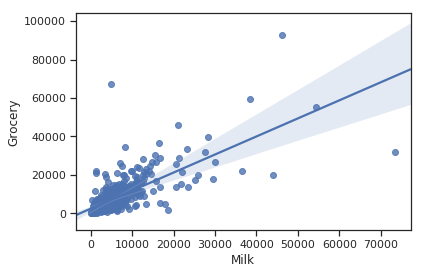

In [111]:
sns.regplot(x="Milk", y="Grocery", data=data)
plt.show()

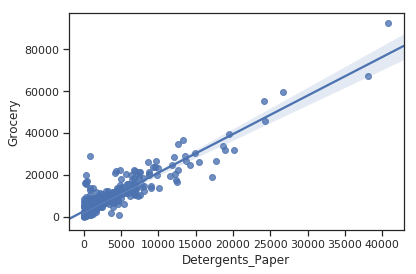

In [112]:
sns.regplot(x=data["Detergents_Paper"], y=data["Grocery"])
plt.show()

In [0]:
#sns.regplot(x="Milk", y="Delicatessen", data=data)

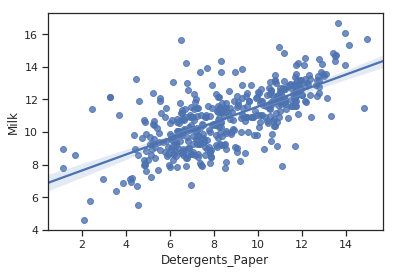

In [134]:
sns.regplot(x="Detergents_Paper", y="Milk", data=data)

**Observation**

*What does the Mean Squared Error Tell You?*

The smaller the means squared error, the closer you are to finding the line of best fit. Depending on your data, it may be impossible to get a very small value for the mean squared error. If i was asked to choose a feature as predicted variable, i would say Milk because mean square error of tree regressor is positive and smallest value. It means Milk is considered as high relevance to other features.

**Data Normalization - Feature Scalling**

As we can see from scatter plot, the data is left sknewed and statistically, mean and standard deviation significantly vary. We have to rescale data before moving to further steps. There are some ways to achieve this scaling such as `natual logarithm` or `Box-Cox test`. In this project, I will use Box-Cox test implemented from `scipy.stats.boxcox`. The **Box Cox transformation** is used to stabilize the variance (eliminate heteroskedasticity) and also to (multi)normalize a distribution. We shall observe the transformed data again in scatter plot to see how well it is rescaled. 





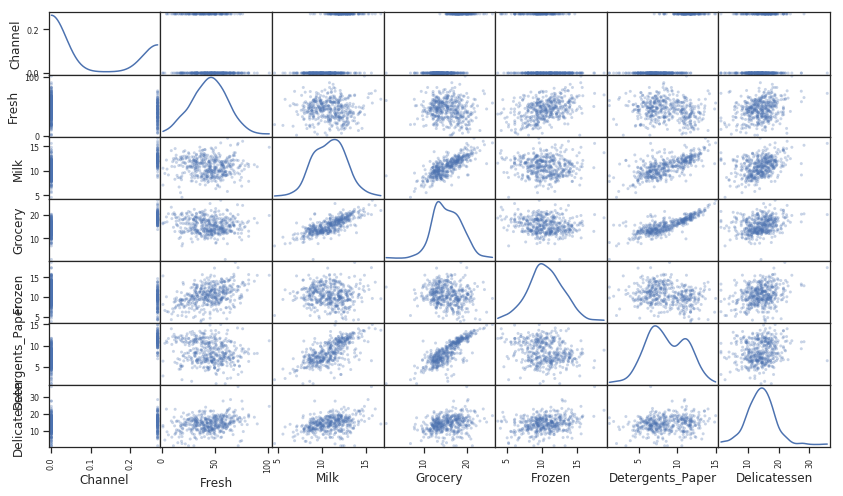

In [115]:

# Filter out Channel and Region columns from dataset
data = data[features]

# Using stats.boxcox to rescale all features
for label in features:
  data[label],_ = stats.boxcox(data[label])
  
# Replot transformed data
pd.plotting.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde')

plt.show()

**Observation**

After applying a Box-Cox scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features we may have identified earlier as still being correlated

In [116]:
display(data[features].describe())

,Channel,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,0.087238,44.845742,10.856013,15.434100,10.443894,8.555818,14.007201
std,0.126521,16.718993,1.854735,3.210891,2.443837,2.592704,4.362090
min,0.000000,1.297776,4.596233,1.179625,3.730425,1.136529,1.222366
25%,0.000000,33.082657,9.470306,13.054012,9.014500,6.610681,11.270068
50%,0.000000,45.615090,10.918724,15.281914,10.359550,8.296571,14.219307
75%,0.270315,56.668564,12.130722,17.794722,12.052169,10.783593,16.723910
max,0.270315,101.573143,16.688053,25.969330,18.774933,14.972315,35.778584


**Observation**

Mean and standard deviation are reduced after normalization and data distribution is less sknewed than before. It seems we are doing the right thing !!!

**Outliers Deletion**

- Anomalies, or outliers, can be a serious issue when training machine learning algorithms or applying statistical techniques. They are often the result of errors in measurements or exceptional system conditions and therefore do not describe the common functioning of the underlying system. Indeed, the best practice is to implement an outlier removal phase before proceeding with further analysis.

- There are many techniques to detect and optionally remove outliers: Numeric Outlier, Z-Score, DBSCAN and Isolation Forest.
  - Numeric Outlier: This is the simplest, nonparametric outlier detection method in a one dimensional feature space. Outliers are calculated by means of the IQR (InterQuartile Range) with interquartile multiplier value k=1.5.
  - Z-score is a parametric outlier detection method in a one or low dimensional feature space. This technique assumes a Gaussian distribution of the data. The outliers are the data points that are in the tails of the distribution and therefore far from the mean
  - This technique is based on the DBSCAN clustering method. DBSCAN is a non-parametric, density based outlier detection method in a one or multi dimensional feature space
  - This is a non-parametric method for large datasets in a one or multi dimensional feature space
- In this project, I will go with **Numeric Outlier** method because it is simple and it can work well because data is already transformed.

- In the code block below, you will need to implement the following:

 - Assign the value of the 25th percentile for the given feature to Q1. Use np.percentile for this.
 - Assign the value of the 75th percentile for the given feature to Q3. Again, use np.percentile.
 - Assign the calculation of an outlier step for the given feature to step.
 - Optionally remove data points from the dataset by adding indices to the outliers list.




In [117]:
# select relevant features in dataset
features = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicatessen']
data =  data[features]

# Create a dictionary to keep datapoints of outliers of each features
outliers_indices = {}

for label in features:

  # 25th percentile
  q1 = np.percentile(data[label], 25)

  # 75th percentile
  q3 = np.percentile(data[label], 75) 

  # Outlier step
  IQR =  (q3 - q1)*1.5

  # Lower Limit
  lower = q1 - IQR

  # Upper Limit
  upper = q3 + IQR

  # Outlier criteria
  not_good_criteria = ~ ((data[label] >= lower) & (data[label] <= upper) )

  # Outlier datapoints selected
  outliers =  data[not_good_criteria]
  
  # Add outliers of the current feature to dictionary
  outliers_indices.update({label: outliers.index.tolist()})
  
  print("Feature: {} , Lower Limit: {}, Upper Limit: {}".format(label, lower, upper))

  display(outliers)


Feature: Fresh , Lower Limit: -2.2962031126927798, Upper Limit: 92.04742418121143


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
181,101.573143,14.821915,19.601092,15.50805,11.172697,24.271947


Feature: Milk , Lower Limit: 5.479683663133844, Upper Limit: 16.121344305687362


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,62.288609,16.688053,21.679025,9.536029,13.638422,13.972230
154,19.248391,4.596233,6.853242,5.270266,2.066981,2.552898


Feature: Grocery , Lower Limit: 5.942947369141335, Upper Limit: 24.90578737700629


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,60.062043,8.986896,1.179625,12.503507,1.136529,14.255725
85,55.798197,15.720152,25.969330,9.607979,14.972315,18.835821


Feature: Frozen , Lower Limit: 4.457996780533938, Upper Limit: 16.60867293600144


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,37.459452,13.586912,19.312695,4.105383,11.753132,11.456670
57,39.504696,12.722615,17.742449,4.299517,11.899624,15.301847
65,9.188742,14.140339,23.052620,4.224827,13.986676,15.715235
93,49.925899,10.642868,12.938974,17.328537,4.872810,18.437994
145,61.528592,12.410476,21.982978,4.438733,12.793740,20.789660
183,72.168663,15.617995,19.974332,17.437506,6.510175,35.778584
325,69.562134,13.711142,18.613583,18.774933,8.975021,21.989377
420,37.101010,11.572219,18.513233,3.730425,11.718648,15.630149


Feature: Detergents_Paper , Lower Limit: 0.35131279660186276, Upper Limit: 17.042960925842717


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen


Feature: Delicatessen , Lower Limit: 3.089305391986576, Upper Limit: 24.90467280410747


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
23,65.063127,15.236169,20.288091,12.837631,10.951341,28.228416
71,58.051662,9.159633,20.125296,12.927220,10.886939,27.391986
87,75.837758,11.489218,16.917970,13.277140,9.312650,27.339709
109,25.412563,13.704848,21.294647,8.838334,8.332239,1.222366
128,11.185311,12.509059,14.645549,6.237033,8.696657,1.222366
142,72.282907,12.121060,16.970631,11.699033,3.289073,1.222366
154,19.248391,4.596233,6.853242,5.270266,2.066981,2.552898
183,72.168663,15.617995,19.974332,17.437506,6.510175,35.778584
184,15.333829,8.646688,15.253508,5.250524,6.983535,3.041318
187,30.495863,12.325237,17.528035,13.262187,10.575590,1.222366


In [118]:
# Most data points are considered as outliers appear in Delicatessen
# However, Detergents_Paper has not outliers after transformation
outliers_indices

{'Delicatessen': [23, 71, 87, 109, 128, 142, 154, 183, 184, 187, 233],
 'Detergents_Paper': [],
 'Fresh': [181],
 'Frozen': [38, 57, 65, 93, 145, 183, 325, 420],
 'Grocery': [75, 85],
 'Milk': [86, 154]}

In [0]:
#TODO
# find duplicated outliers found in more than one feature

In [120]:
# Some outliers appear in more than one feature
# We have to remove the duplication before drop it out dataset

# Remove outliers
good_data = data[features].copy()
print("before : {}".format(len(good_data)))
try:
  for key in outliers_indices:
    good_data.drop(outliers_indices[key], inplace=True)
except:
  print("error found while dropping data of : {}".format(key))

print("after: {}".format(len(good_data)))

before : 440
error found while dropping data of : Delicatessen
after: 427


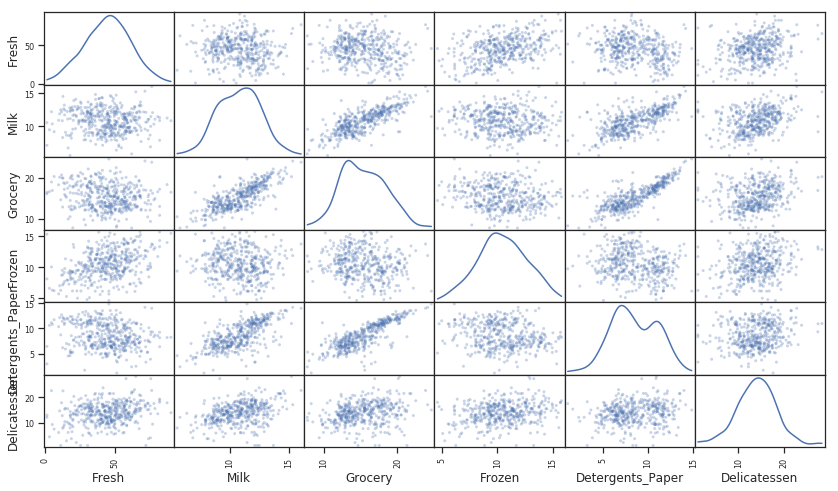

In [121]:
pd.plotting.scatter_matrix(good_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde')
plt.show()

**Feature Relevance**

- One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

- Using `DecisionTreeRegressor` to predict which feature is most relevant to be target variable. Based one `mean squared error` (the smaller, the better) score returned from regressor, we can probably guess the feature with lowest possitve score

mse score: Fresh : -33.48651789043693
mse score: Milk : 49.19784827671084
mse score: Grocery : 51.745695388420586
mse score: Frozen : -79.3754399346808
mse score: Detergents_Paper : 39.38875455449594
mse score: Delicatessen : -63.6357003449878


<Figure size 720x576 with 0 Axes>

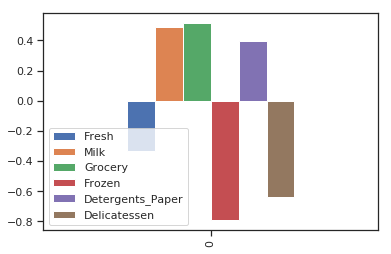

In [122]:

data_copy = good_data[features].copy()

#print(data_copy.head())

scores = {}


for column in features:
  
  target = data_copy[column]
  new_data = data_copy.drop([column], axis=1)
   
  x_train, x_test, y_train, y_test =  train_test_split(new_data, target, test_size=0.2, random_state=0)
  
  tree = DecisionTreeRegressor()
  
  #cv_results = cross_val_score(tree, x_train, y_train, cv=3)
  
  #print("Label: {}".format(column))
  
  #print("CV test score: {}".format(cv_results))
  tree.fit(x_train, y_train)
#  tree.predict(x_test)
  
  mse = tree.score(x_test, y_test)
  
  print("mse score: {} : {}".format(column, mse*100))
  
  scores.update({column:[mse]})
  


pd_score = pd.DataFrame(scores)

plt.figure(figsize=(10, 8))
pd_score.plot(kind='bar')
plt.legend(loc=3)
plt.show()

**Observation**

- Negative scores means the feature fails to be predicted. Delicatessen & Fresh & Frozen can't be considered as target variable. The feature with lowerest positive score is Detergents_Paper which is should be most relevant feature in dataset



**Feature Transformation**

- Now we are done with data processing. We shall use PCA (Principal Components Analysis) in `sklearn` to extract the important features in the dataset. When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained.

- After transforming data, we shall plot  new data along with `explained variance ratio` of each compoment in bar chart



In [0]:
def pca_results(good_data, pca):
	'''
	Create a DataFrame of the PCA results
	It includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
  # dimensions = ['Dimension 1', 'Dimension 2', ...]
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Create a bar plot visualization
	fig, ax = plt.subplots(figsize = (14,8))

	# Plot the feature weights as a function of the components
	components.plot(ax = ax, kind = 'bar');
	ax.set_ylabel("Feature Weights")
	ax.set_xticklabels(dimensions, rotation=0)


	# Display the explained variance ratios
	for i, ev in enumerate(pca.explained_variance_ratio_):
		ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n%.4f"%(ev))

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)

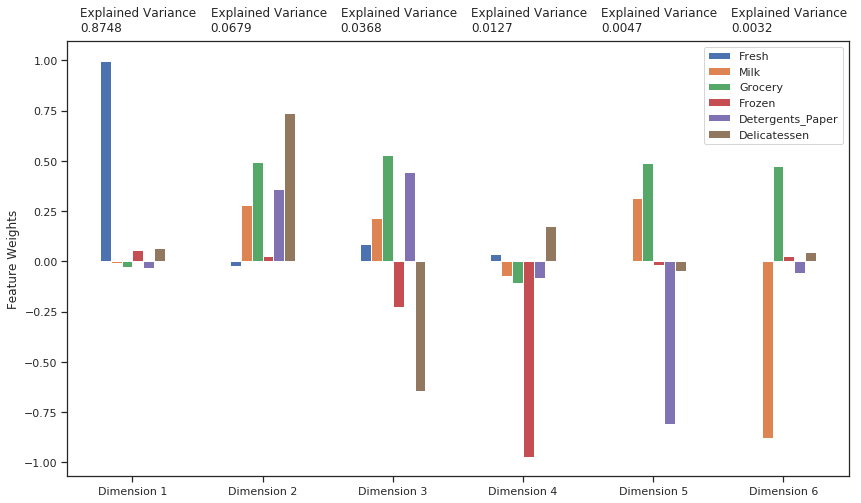

In [124]:
# the number of components equals the number of features in dataset
n_components = len(good_data.columns)

pca = PCA(n_components)

pca_data = pca.fit_transform(good_data)

pca_result = pca_results(good_data, pca)

**Observation**

The plot above clearly shows that most of the variance (87.48% of the variance to be precise) can be explained by the first principal component alone. The second principal component still bears some information (6.79%) while the third, fourth, fifth and sixth principal components can safely be dropped without losing to much information. Together, the first two principal components contain 94.27% of the information.

In [0]:
def biplot(good_data, reduced_data, pca):
    '''
    
    Produce a biplot that shows a scatterplot of the reduced
    data and the projections of the original features.
    
    good_data: original data, before transformation.
               Needs to be a pandas dataframe with valid column names
    reduced_data: the reduced data (the first two dimensions are plotted)
    pca: pca object that contains the components_ attribute

    return: a matplotlib AxesSubplot object (for any additional customization)
    
    This procedure is inspired by the script:
    https://github.com/teddyroland/python-biplot
    
    '''

    fig, ax = plt.subplots(figsize = (14,8))
    # scatterplot of the reduced data    
    ax.scatter(x=reduced_data.loc[:, 'Dimension 1'], y=reduced_data.loc[:, 'Dimension 2'], 
        facecolors='b', edgecolors='b', s=70, alpha=0.5)
    
    feature_vectors = pca.components_.T

    # we use scaling factors to make the arrows easier to see
    arrow_size, text_pos = 5.0, 5.0,

    # projections of the original features
    for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], 
                  head_width=0.2, head_length=0.2, linewidth=2, color='red')
        
        ax.text(v[0]*text_pos, v[1]*text_pos, good_data.columns[i], color='black', 
                 ha='center', va='center', fontsize=18)

    ax.set_xlabel("Dimension 1", fontsize=14)
    ax.set_ylabel("Dimension 2", fontsize=14)
    ax.set_title("PC plane with original feature projections.", fontsize=16);
    
    return ax

**Standardizing & Dimensionality Reduction**

- We will biplot data again with 2 principal components in in 2D scatterplot where each datapoint is represented by its scores along the principal components. In addition, the biplot shows the projection of the original features along the components. A biplot can help us interpret the reduced dimensions of the data, and discover relationships between the principal components and original features.

- Prior to PCA, it makes sense to standardize the data, especially, if it was measured on different scales. 


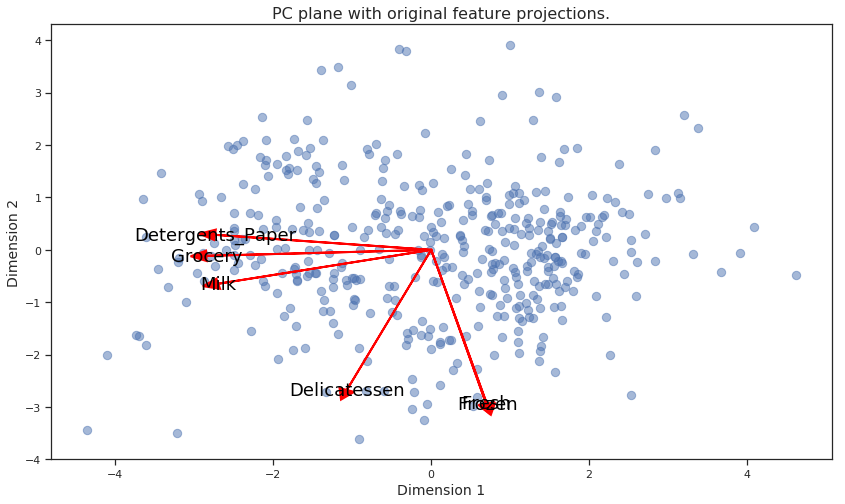

In [126]:


data_std = StandardScaler().fit_transform(good_data)

pca = PCA(n_components=2)

transformed_data = pca.fit_transform(data_std)

pd_transformed_data = pd.DataFrame(transformed_data, columns = ['Dimension 1', 'Dimension 2'])

biplot(good_data, pd_transformed_data, pca)

plt.show()

**Observation**

- There is high correlation in spending of clients who buy Frozen and Fresh products.
- However, clients who buy Grocery products who will buy Detergents_Paper and Milk products.
-  Delicatessen seems unrelates to other products.

** Clustering with Agglomerative Clustering algorithm**

Agglomerative Clustering algorithm groups similar objects into groups called clusters. It recursively merges the pair of clusters that minimally increases a given linkage distance. It starts with many small clusters and merge them together to create bigger clusters:



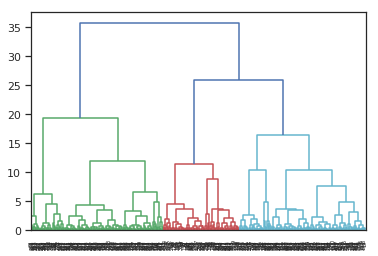

In [127]:


dendrogram = sch.dendrogram(sch.linkage(transformed_data, method='ward'))

What is the number of cluster to be considered as a good parameter to algorithm for this case? Using sklearn.metrics.silhouette_score to calculate the distance between features and clusters. We choose the value with the highest score:

In [128]:

for i in range(2, len(features) + 1):
  model = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward')
  model.fit(transformed_data)
  labels = model.labels_
  score = silhouette_score(transformed_data, labels, metric='euclidean')
  print("Cluster: {}, score: {}".format(i, score))


Cluster: 2, score: 0.31464135811015653
Cluster: 3, score: 0.299218354075286
Cluster: 4, score: 0.29332856881138303
Cluster: 5, score: 0.31285975761587975
Cluster: 6, score: 0.2978440686133343


**Observation**

Clearly, Model returns the highest score with cluster=2. Fitting model with data which is transformed and plotting clustered data:

In [129]:
model = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
model.fit(transformed_data)
labels = model.labels_
centers = model.n_connected_components_
preds = model.fit_predict(transformed_data)
score = silhouette_score(transformed_data, labels, metric='euclidean')
print(score)


0.31464135811015653


In [0]:
def cluster_results(reduced_data, preds, centers):
	'''
	Visualizes the PCA-reduced cluster data in two dimensions
	Adds cues for cluster centers and student-selected sample data
	'''

	predictions = pd.DataFrame(preds, columns = ['Cluster'])
	plot_data = pd.concat([predictions, reduced_data], axis = 1)

	# Generate the cluster plot
	fig, ax = plt.subplots(figsize = (14,8))

	# Color map
	cmap = cm.get_cmap('gist_rainbow')

	# Color the points based on assigned cluster
	for i, cluster in plot_data.groupby('Cluster'):   
	    cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
	                 color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);

	# Plot centers with indicators
	for i, c in enumerate(centers):
	    ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
	               alpha = 1, linewidth = 2, marker = 'o', s=200);
	    ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);

	# Set plot title
	ax.set_title("Cluster Learning on PCA-Reduced Data - Centroids Marked by Number\nTransformed Sample Data Marked by Black Cross");

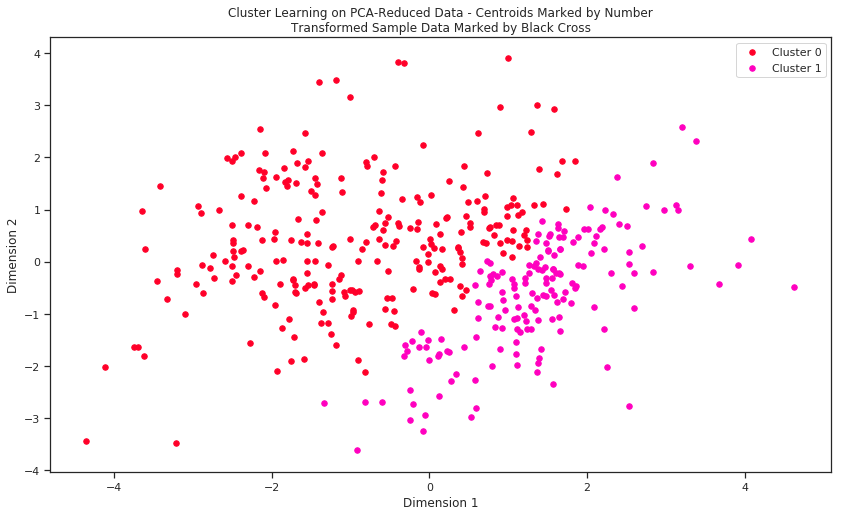

In [131]:
#cluster_results(transformed_data, preds, centers)
predictions = pd.DataFrame(preds, columns = ['Cluster'])
plot_data = pd.concat([predictions, pd_transformed_data], axis = 1)
	# Generate the cluster plot
fig, ax = plt.subplots(figsize = (14,8))
	# Color map
cmap = cm.get_cmap('gist_rainbow')

# Color the points based on assigned cluster
for i, cluster in plot_data.groupby('Cluster'):   
    cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
                color = cmap((i)*1.0),label = 'Cluster %i'%(i), s=30);
# Set plot title
ax.set_title("Cluster Learning on PCA-Reduced Data - Centroids Marked by Number\nTransformed Sample Data Marked by Black Cross");

**Channel & Products Distrubution**

In [132]:
pd_channel = pd.read_csv(path + filename)

print("before: {}".format(len(pd_channel)))
try:
  for key in outliers_indices:
    pd_channel.drop(outliers_indices[key], inplace=True)
except:
  print("error found while dropping data of : {}".format(key))

print("after: {}".format(len(pd_channel)))


before: 440
error found while dropping data of : Delicatessen
after: 427


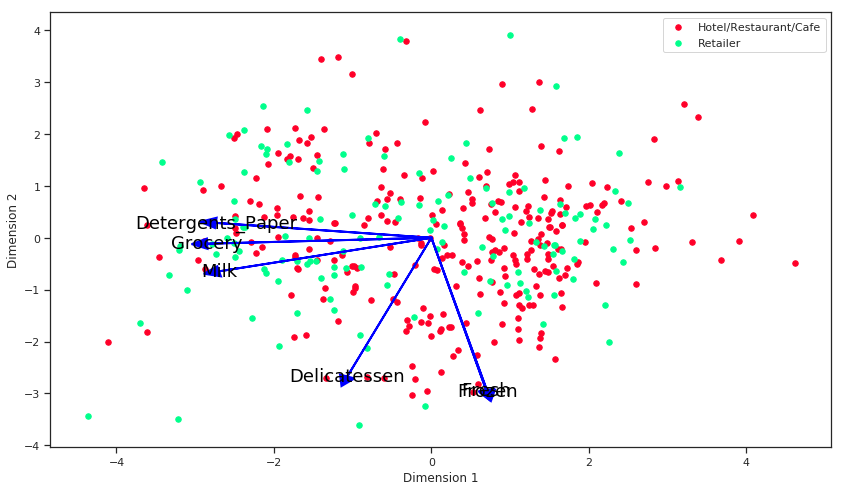

In [133]:
pd_channel = pd_channel[['Channel']]

# Generate the cluster plot
fig, ax = plt.subplots(figsize = (14,8))

# Color map
cmap = cm.get_cmap('gist_rainbow')

# Color the points based on assigned Channel
labels = ['Hotel/Restaurant/Cafe', 'Retailer']
# Merge feature dataframe & channel dataframe
labeled = pd.concat([pd_transformed_data, pd_channel], axis = 1)
# drop Na values after merging 2 dataframes
labeled.dropna(inplace=True)
# convert value type from float into integer
labeled['Channel'] = labeled['Channel'].astype(int)

grouped = labeled.groupby('Channel')
for i, channel in grouped:   
    channel.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
                 color = cmap((i-1)*1.0/2), label = labels[i-1], s=30);

feature_vectors = pca.components_.T

# we use scaling factors to make the arrows easier to see
arrow_size, text_pos = 5.0, 5.0,

# projections of the original features 
for i, v in enumerate(feature_vectors):
    ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], 
              head_width=0.2, head_length=0.2, linewidth=2, color='blue')

    ax.text(v[0]*text_pos, v[1]*text_pos, good_data.columns[i], color='black', 
             ha='center', va='center', fontsize=18)